<a href="https://colab.research.google.com/github/Dkreitzer/Text_ML_Classification_UMN/blob/master/Doc_Classification_MD_Draft.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**bold text**# references
https://towardsdatascience.com/applying-machine-learning-to-classify-an-unsupervised-text-document-e7bb6265f52


# Imports and Installs

In [2]:
#@title  { vertical-output: true }
#@markdown this is random markdown

!pip install markdown2
from __future__ import print_function
from nltk.stem.snowball import SnowballStemmer
import string
from nltk.tag import pos_tag
from gensim import corpora, models, similarities
from sklearn.externals import joblib
from sklearn.metrics import euclidean_distances
from sklearn.metrics.pairwise import cosine_similarity
import colorsys
import markdown2


import seaborn as sns
from scipy.sparse import coo_matrix
from sklearn.metrics import silhouette_samples, silhouette_score
import sys
from operator import itemgetter
import time
from tqdm.auto import tqdm
import re

from datetime import datetime
from nltk.corpus import stopwords
from nltk import word_tokenize, sent_tokenize
from nltk.stem import PorterStemmer
from nltk import pos_tag
import nltk
import math
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from matplotlib import figure
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.cluster import KMeans
from sklearn import metrics
from IPython.display import display, HTML

import numpy as np  ##20.2
import pandas as pd
from pandas.io.common import EmptyDataError

import matplotlib
from pathlib import Path
import shutil
import string

import ipywidgets as widgets


nltk.download('punkt')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')

%matplotlib inline

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


#Downloading Files


In [0]:
#@title Get/Replace Github { display-mode: "form" }
get_new = False #@param {type:"boolean"}

remove_old = False #@param {type:"boolean"}
if remove_old:
  double_check = input(
      'Make sure to backup master_data.csv Enter "Delete" to continue? ').lower()
  if double_check == "delete":
      !rm -rf Text_ML_Classification_UMN
if get_new:
    !git clone https://github.com/Dkreitzer/Text_ML_Classification_UMN
      

In [0]:
  #@title Move Files for Testing
#   shutil.move('Text_ML_Classification_UMN/Train/Text_Files_Trained/ASGN_Incorporated.txt', 'Text_ML_Classification_UMN/Analyze')
#   shutil.move("Text_ML_Classification_UMN/Train/Text_Files_Trained/AAR_Corp_.txt", 'Text_ML_Classification_UMN/Analyze')
#   shutil.move("Text_ML_Classification_UMN/Train/Text_Files_Trained/2U_Inc_.txt", 'Text_ML_Classification_UMN/Analyze')
#   shutil.move("Text_ML_Classification_UMN/Train/Text_Files_Trained/3M_Company.txt", 'Text_ML_Classification_UMN/Analyze')
#   shutil.move("Text_ML_Classification_UMN/Train/Text_Files_Trained/ADT_Inc_.txt", 'Text_ML_Classification_UMN/Analyze')
#   shutil.move("Text_ML_Classification_UMN/Train/Text_Files_Trained/180_Degree_Capital_Corp_.txt", 'Text_ML_Classification_UMN/Analyze')


In [1]:
#@title get_time() { vertical-output: true }
def get_time():
    current_time = datetime.now().strftime("%b%d-%I%M%p")
    return current_time
get_time()

NameError: ignored

In [0]:
#@title get_documents() { vertical-output: true }

def get_documents(NUMBER_OF_DOCS):
    doclist = []
    names = []
    # %cd "
    pathlist = Path(
        "Text_ML_Classification_UMN/Train/Text_Files_Trained").glob('**/*.txt')

    for path in tqdm(pathlist):
        path_in_str = str(path)
    #     print(path_in_str)
        name = path_in_str.split(".")[0].split("/")[3]
        names.append(name.replace("_", " "))
        # TODO SPLIT PATH TO COMPANY NAME, make Index
        file = open(path, "r", encoding= 'Windows-1252')
        # print "Output of Readlines after appending"
        text = file.readlines()
    #     print(text[:10])
        doclist.append(text[0])
      
      
            
    df_to_split = pd.DataFrame(list(zip(names, doclist)),
                               columns=['Company', 'Text'])
    split_df = df_to_split.sample(n=NUMBER_OF_DOCS, random_state=42)
    doclist, names =  split_df["Text"].tolist(), split_df["Company"].tolist()
    print(split_df.head())
    
    
    
    return doclist, names
doclist, names = get_documents(100)


                               Company  \
1947      Third Point Reinsurance Ltd    
1309                       Agenus Inc    
1606     Apollo Investment Corporation   
2626  AmpliPhi Biosciences Corporation   
2440                       Biogen Inc    

                                                   Text  
1947  [1] "Item 1A. Risk Factors. You should conside...  
1309  [1] "Item 1A.  Risk Factors. Our future operat...  
1606  [1] "Item 1A. Risk Factors. Investing in Apoll...  
2626  [1] "Item 1A.     RISK FACTORS. You should con...  
2440  [1] "Item  1A.     Risk Factors. We are substa...  


# Vectorization
In order to run the model, we need to turn words in to numbers <br>
First, we turn each document into Sentences or tokens <a href="#Token">Tokenization</a>  <br>
To remove digits, useless words and characters we use a  <a href="#Filter">Filter</a>   <br>
Finally, we <a href="#Stem">Stem</a>   each token into its word root <br>
Then we can use some sort of <a href="#Vector">Vectorizer</a> to generate our input!


In [0]:
#@title transform_tokens() { vertical-output: true, display-mode: "form" }
def transform_tokens(doclist):
    token_list = []
    for doc in tqdm(doclist, desc="Tokenizing", leave=True, position=0):
        dirty_tokens = nltk.sent_tokenize(doc)
        token_list += [dirty_tokens]
    return token_list
tokens = transform_tokens(doclist)
tokens[0][:5]

['[1] "Item 1A.',
 'Risk Factors.',
 'You should consider and read carefully all of the risks and uncertainties described below, as well as other information included in this Annual Report, including our consolidated financial statements and related notes.',
 'The risks described below are not the only ones facing us.',
 'The occurrence of any of the following risks or additional risks and uncertainties not presently known to us or that we currently believe to be immaterial could materially and adversely affect our business, financial condition or results of operations.']

In [0]:
#@title transform_filtered() { vertical-output: true, display-mode: "form" }
def transform_filtered(token_list, doclist, names):

    punc = ['.', ',', '"', "'", '?', '!', ':',
            ';', '(', ')', '[', ']', '{', '}', "%"]
    more_stops = ['\t',
                  '\\t\\t\\', '\\t\\t\\t',
                  '<U+25CF>', '<u+feff>',  '[1]', 'feff', '1a', 'item']
    maybe_bad_stops = ['may', 'could',  'contents',
                       'table', 'time', '25cf', 'factors', 'risk']
    stopwords_list = stopwords.words(
        'english') + more_stops + punc + maybe_bad_stops
    filtered_tokens = []
    names_list = []
    
    if type(token_list) != list:
        token_list = [token_list]
    index = 0
              
    for document in tqdm(token_list, desc="Filtering Documents"):
        name = names[index]
        for token in document:
            filtered_token = [word.lower() for word in token.split(
                " ") if word.lower() not in stopwords_list and word.isalpha()]
            filtered_token = ' '.join(filtered_token)
            if len(filtered_token) != 0:
                names_list.append(name)
                filtered_tokens.append(filtered_token)
        index += 1
    
    return filtered_tokens, names_list, stopwords_list
  
  
filtered_tokens, names_list, stopwords_list = \
transform_filtered(tokens, doclist, names)
filtered_tokens[:25]


['consider read carefully risks uncertainties described well information included annual including consolidated financial statements related',
 'risks described ones facing',
 'occurrence following risks additional risks uncertainties presently known us currently believe immaterial materially adversely affect financial condition results',
 'annual report also contains statements estimates involve risks',
 'actual results differ materially anticipated statements result specific including risks uncertainties described risks related',
 'results operations fluctuate period period indicative',
 'performance reinsurance operations investment portfolio fluctuate period',
 'fluctuations result variety',
 'performance investment',
 'reinsurance contract',
 'assessment quality available reinsurance',
 'volume mix reinsurance products',
 'loss experience reinsurance',
 'ability assess integrate management strategy',
 'seek underwrite products make investments achieve favorable return equity long'

In [0]:
#@title transform_stemming() { vertical-output: true, display-mode: "form" }
def transform_stemming(filtered_tokens):
    stemmed = []
    for token in tqdm(filtered_tokens, desc="Stemming"):
        sentence = []
        stemmed_token = \
        [PorterStemmer().stem(word) for word in token.split(" ")]
        stemmed_token = \
        [word for word in stemmed_token if word not in stopwords_list]
#         stemmed_token = \
#         [LancasterStemmer().stem(word) for word in token.split(" ")]
#         stemmed_token = \
#         [SnowballStemmer('english').stem(word) for word in token.split(" ")]

        stemmed_token = ' '.join(stemmed_token)
        stemmed.append(stemmed_token)

    return stemmed

  
stemmed = transform_stemming(filtered_tokens)
stemmed[:5]

['consid read care uncertainti describ well inform includ annual includ consolid financi statement relat',
 'describ one face',
 'occurr follow addit uncertainti present known us current believ immateri materi advers affect financi condit result',
 'annual report also contain statement estim involv',
 'actual result differ materi anticip statement result specif includ uncertainti describ relat']

In [0]:
#@title transform_vectorize() { vertical-output: true, form-width: "50%", display-mode: "form" }
#@markdown TF-IDF Vectorizer

def transform_vectorize(stemmed, smallest_ngram, largest_ngram):

    vectorizer = TfidfVectorizer(stop_words=stopwords_list,
                                 ngram_range=(smallest_ngram, largest_ngram),
                                 max_df=0.55, min_df=0.01)
    count_vectorizer = CountVectorizer(stop_words=stopwords_list,
                                   ngram_range=(smallest_ngram, largest_ngram),
                                   max_df=0.75, min_df=0.01)
    sparseMatrix = vectorizer.fit_transform(stemmed)
    
    return sparseMatrix, vectorizer, count_vectorizer
 


smallest_ngram = 1
largest_ngram = len(max(tokens, key=len))
%time sparseMatrix, vectorizer, count_vectorizer = \
transform_vectorize(stemmed, smallest_ngram, largest_ngram)
vectorizer

CPU times: user 32.4 s, sys: 1.41 s, total: 33.8 s
Wall time: 33.8 s


TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=0.55, max_features=None, min_df=0.01,
        ngram_range=(1, 819), norm='l2', preprocessor=None,
        smooth_idf=True,
        stop_words=['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs',...)', '[', ']', '{', '}', '%', 'may', 'could', 'contents', 'table', 'time', '25cf', 'factors', 'risk'],
        strip_accents=None, sublinear_tf=False,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None)

In [0]:
#@title Matrix as array { vertical-output: true, form-width: "50%", display-mode: "form" }
vector_array = sparseMatrix.toarray()
print(vector_array, sparseMatrix.shape)
# count_matrix = count_vectorizer.fit_transform(stemmed).toarray() 
# print(count_matrix, count_matrix.shape)


[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]] (35286, 354)


In [0]:
#@title Visualizing The Vectors { vertical-output: true, form-width: "50%" }

def plot_coo_matrix(m):
    if not isinstance(m, coo_matrix):
        m = coo_matrix(m)
    fig = plt.figure(figsize=(50,50))
    ax = fig.add_subplot(354, facecolor='black')
    ax.plot(m.col, m.row, 's', color='blue', markersize=1)
    ax.set_xlim(0, m.shape[1])
    ax.set_ylim(0, m.shape[0])
    ax.set_aspect('auto')
    for spine in ax.spines.values():
        spine.set_visible(False)
    ax.invert_yaxis()
    ax.set_aspect('equal')
    ax.set_xticks([])
    ax.set_yticks([])
    return ax

 
# print(sparseMatrix.shape)
plot_coo_matrix(sparseMatrix.T).figure.show
# spy()

# fig = plt.figure()
# ax = fig.add_subplot(354, facecolor='black')


<bound method Figure.show of <Figure size 3600x3600 with 1 Axes>>

# Model Training

In [0]:
#@markdown ### print_score() { display-mode: "code" }
def print_score(model, vectorizer, stemmed):
    labels = model.labels_

#     print(f"Model Generated at {model_time}")

    print("Cluster id labels for inputted data")
    print(labels)
    print("Centroids data")
    #print (centroids)
    print("Paramaters")
    print(model.get_params)
    sparseMatrix = vectorizer.fit_transform(stemmed)
    kmeans_score = model.score(sparseMatrix)
    print("Score (Opposite of the value of X on the K-means objective, \n",
          "which is Sum of distances of samples to their closest cluster center):")
    print(kmeans_score)

    silhouette_score = metrics.silhouette_score(
        sparseMatrix, labels, metric='euclidean')

    print("Silhouette_score: ", silhouette_score)

    
    
    return kmeans_score, silhouette_score, sparseMatrix


In [0]:
#@title Grid Search { run: "auto", vertical-output: true, display-mode: "form" }
max_iter = 10, 50, #@param {type:"raw"}
n_clusters = 10, 20, 25, 30, 35,21,13,14,15 #@param {type:"raw"}

cross_validation_folds = 4 #@param {type:"integer"}
n_jobs = 100 #@param {type:"slider", min:1, max:1000, step:1}
verbose = 10 #@param {type:"slider", min:1, max:10, step:1}
run_gridsearch = False #@param {type:"boolean"}
from sklearn.model_selection import GridSearchCV
if run_gridsearch:
    model = KMeans(init='k-means++', random_state=42, n_init=15
                       )
    param_grid = {'max_iter': list(max_iter),
                 'n_clusters': list(n_clusters),

                 }
    grid = GridSearchCV(model, param_grid, verbose=verbose, n_jobs=n_jobs, cv=cross_validation_folds)
    grid.fit(sparseMatrix)

    # lids = model.cluster_centers_

    score = model.score(sparseMatrix)
    silhouette_score = metrics.silhouette_score(sparseMatrix, labels, metric='euclidean')

    # # List the best parameters for this dataset
    print(grid.best_params_)
    # # List the best score
    print(grid.best_score_)

In [0]:
#@markdown ##Kmeans
#@markdown <img src='https://upload.wikimedia.org/wikipedia/commons/d/d5/Kmeans_animation.gif'>

def estimator_cluster(sparseMatrix, vectorizer, params):
    model = KMeans(n_clusters=params['n_clusters'], init=params['init'],
                   max_iter=params['max_iter'], n_init=n_init,
                   random_state=params['random_state'],
                   precompute_distances = params['precompute_distances'],
                   verbose=params['verbose'], 
#                    n_jobs=params['n_jobs']
)
    model.fit(sparseMatrix)
#     import umap

#     model = umap.UMAP(n_neighbors=5,
#                       min_dist=0.3,
#                       metric='correlation').fit_transform(sparseMatrix)
    
    model_time = get_time()
    model_path = f'Text_ML_Classification_UMN/Model/model{model_time}.pkl'
    joblib.dump(model,  model_path)
    joblib.dump(vectorizer,  f'Text_ML_Classification_UMN/Model/vec{model_time}.pkl')
    order_centroids = model.cluster_centers_.argsort()[:, ::-1]
#     order_centroids = False
    terms = vectorizer.get_feature_names()
    print('Model Saved to %s' % model_path)
    return terms, order_centroids, model, n_clusters, model_time

In [0]:
#@title Model Parameters { run: "auto" }
init = "k-means++" #@param ["Pre-Labeled",'k-means++']
if init == "Pre-Labeled":
  init = get_topics(topics)
  n_clusters = init.shape[0]
else:
  n_clusters = 35 #@param {type:"integer"}

max_iter=50  #@param {type:"integer"}
n_init= 10 #@param {type:"slider", min:0, max:100, step:1}
random_state=42  #@param {type:"integer"}
save_memory = False #@param ["False", "True"] {type:"raw"}
verbose = 0 #@param {type:"slider", min:0, max:10, step:1}
# n_jobs = 1 #@param {type:"slider", min:1, max:100, step:1}



params = {"n_clusters" : n_clusters, "max_iter" : max_iter,
          'n_init' : n_init, 'random_state': random_state,
          'precompute_distances': save_memory, 'init': init,
         'verbose' : verbose, 
#           'n_jobs': n_jobs
         }


In [0]:
#@title Generate Model { vertical-output: true, output-height: 250 }
#@markdown #### Q.) This takes a long time so why not use a Hashing technique?
#@markdown #### A.)  We would not be able to get the vocab back, critical for this unsupervised problem

%time terms, order_centroids, model, n_clusters, model_time =  \
  estimator_cluster(sparseMatrix, vectorizer, params)
# kmeans_score, silhouette_score, sparseMatrix = print_score(model,vectorizer,stemmed)

Model Saved to Text_ML_Classification_UMN/Model/modelMar20-0920AM.pkl
CPU times: user 3min 3s, sys: 39.6 s, total: 3min 42s
Wall time: 2min 54s


In [0]:
#@title Move Files? { display-mode: "form" }

train_to_history = False #@param {type:"boolean"}
analyze_to_history = False #@param {type:"boolean"}
train_to_analyze = False #@param {type:"boolean"}


def move_txt_files(analysis_to_history, train_to_history, train_to_analyze):
    if train_to_history or train_to_analyze:
        pathlist = Path(
            "Text_ML_Classification_UMN/Train/Text_Files_Trained").glob('**/*.txt')
     
    if analyze_to_history:
        pathlist = Path(
            "/Text_ML_Classification_UMN/Analyze").glob('**/*.txt')
    
    if analyze_to_history or train_to_history:
        for path in tqdm(pathlist):
            shutil.move(str(path), 'Text_ML_Classification_UMN/History/Text_Files_History')
    
    if analyze_to_history or train_to_history:
        for path in tqdm(pathlist):
            shutil.move(str(path), 'Text_ML_Classification_UMN/Analyze')

move_txt_files(analyze_to_history, train_to_history)

# Loading Model

In [0]:
#@markdown ### load master_data() { display-mode: "form" }
def load_master_data():
    master_path = 'Text_ML_Classification_UMN/Predicting/CSV/master_data.csv'
    try:
        master = pd.read_csv(master_path)
        master = master.set_index('label')
    except FileNotFoundError:
        master = False
    
    return master

In [0]:
#@markdown ### estimator_load_model()
def estimator_load_model(selection, stemmed):
      print(selection)
      model_time = selection
      vectorizer = joblib.load(
          f'Text_ML_Classification_UMN/Model/vec{model_time}.pkl')
      model = joblib.load(
          f'Text_ML_Classification_UMN/Model/model{model_time}.pkl')
      if stemmed:
          kmeans_score, silhouette_score, sparseMatrix = \
            print_score(model, vectorizer, stemmed)
      n_clusters = model.n_clusters
      
      return model, vectorizer, n_clusters

In [0]:
#@title Model Selection { run: "auto", vertical-output: true, display-mode: "form" }

pathlist = Path(
        "Text_ML_Classification_UMN/Model/").glob('**/*.pkl')

times = set([str(path).split(".pkl")[0].split("/")[2].replace(
        "model", "").replace("vec", "") for path in pathlist])
selection = widgets.Dropdown(
        options=times,
        description='Available Models:',
        disabled=False,
    )
display(selection)
time = selection.value
model, vectorizer, n_clusters = estimator_load_model(time, stemmed)

Dropdown(description='Available Models:', options=('Mar20-0907AM', 'Feb14-0130PM', 'Mar20-0526AM', 'Mar20-0920…

Mar20-0907AM
Cluster id labels for inputted data
[ 4 11 14 ... 11 15 11]
Centroids data
Paramaters
<bound method BaseEstimator.get_params of KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=50,
    n_clusters=35, n_init=1, n_jobs=None, precompute_distances=False,
    random_state=42, tol=0.0001, verbose=0)>
Score (Opposite of the value of X on the K-means objective, 
 which is Sum of distances of samples to their closest cluster center):
-29100.470910799337
Silhouette_score:  0.03825334711850074


In [0]:
#@title Define Cluster Labels { run: "auto", vertical-output: true, display-mode: "form" }
num_words_to_show = 10 #@param {type:"slider", min:1, max:25, step:1}

#  https://stackoverflow.com/questions/876853/generating-color-ranges-in-python
order_centroids = model.cluster_centers_.argsort()[:, ::-1]
terms = vectorizer.get_feature_names()

def get_N_HexCol(N):
    HSV_tuples = [(x * 1.0 / N, 0.5, 0.5) for x in range(N)]
    hex_out = []
    for rgb in HSV_tuples:
        rgb = map(lambda x: int(x * 255), colorsys.hsv_to_rgb(*rgb))
        hex_out.append('#%02x%02x%02x' % tuple(rgb))
    return hex_out

colormap = get_N_HexCol(n_clusters)



for label in range(n_clusters):
    nclosest_words = []
    color = colormap[label]
    display(HTML(f'<font color="{color}">Cluster {label}</font>'))
    for ind in order_centroids[label, :num_words_to_show]:
       nclosest_words.append(terms[ind])
    display(HTML(f'<font color="{color}">{nclosest_words}</font>'))

    

# Predictions

In [0]:
#@title Predict String() { run: "auto", vertical-output: true, display-mode: "form" }

def estimator_predict_string(string):
    string_in_a_list = ["string"]
    
    print('Input String: %s' % string)
    print('\n')
    print('Prediction:')
    tokens = transform_tokens(string_in_a_list)
    filtered_tokens, _ , _ = transform_filtered(tokens, string_in_a_list, string_in_a_list)
    stemmed = transform_stemming(filtered_tokens)
    X = vectorizer.transform(stemmed)
    predicted = model.predict(X)



    color = colormap[predicted[0]]
    display(HTML(f'<font color="{color}">Predicted Cluster : {predicted[0]}</font>'))
    for ind in order_centroids[predicted[0], :10]:
       nclosest_words.append(terms[ind])
    display(HTML(f'<font color="{color}">{nclosest_words}</font>'))

    


Enter_a_String = 'The Martians are taking our jobs!' #@param {type:"string"}

estimator_predict_string(Enter_a_String)

Input String: The Martians are taking our jobs!


Prediction:


In [0]:
#@title Potential Topics { vertical-output: true }

#@markdown SUMMARIZATION OF CORPORATE RISK FACTOR DISCLOSURE THROUGH TOPIC MODELING by Bao, Datta
strings = [
    'Topic 0: investment, property, distribution, interest, agreement',
    'Topic 1: regulation, change, law, financial, operation, tax, accounting ',
    'Topic 2: gas, price, oil, natural, operation, production Input prices risks ',
    'Topic 3: stock, price, share, market, future, dividend, security, stakeholder ',
    'Topic 4: cost, regulation, environmental, law, operation, liability',
    'Topic 5: control, financial, internal, loss, reporting, history ',
    'Topic 6: financial, litigation, operation, condition, action, legal, liability, regulatory, claim, lawsuit'
    'Topic 7: competitive, industry, competition, highly',
    'Topic 8: cost, operation, labor, operating, employee, increase, acquisition ',
    'Topic 9: product, candidate, development, approval, clinical, regulatory',
    'Topic 10: tax, income, asset, net, goodwill, loss, distribution, impairment, intangible ',
    'Topic 11: interest, director, officer, trust, combination, share, conflict ',
    'Topic 12: product, liability, claim, market, insurance, sale, revenue Potential defects in products',
    'Topic 13: loan, real, estate, investment, property, market, loss, portfolio ',
    'Topic 14: personnel, key, retain, attract, management, employee ',
    'Topic 15: stock, price, operating, stockholder, fluctuate, interest, volatile  ',
    'Topic 16: acquisition, growth, future, operation, additional, capital, strategy ',
    'Topic 17: condition, economic, financial, market, industry, change, affected, downturn, demand Macroeconomic risks ',
    'Topic 18: system, service, information, failure, product, operation, software, network, breach, interruption Disruption of operations'
    'Topic 19: cost, contract, operation, plan, increase, pension, delay',
    'Topic 20: customer, product, revenue, sale, supplier, relationship, key, portion, contract, manufacturing, rely Rely on few large customers',
    'Topic 21: property, intellectual, protect, proprietary, technology, patent, protection, harm',
    'Topic 22: product, market, service, change, sale, demand, successfully, technology, competition Volatile demand and results',
    'Topic 23: provision, law, control, change, stock, prevent, stockholder, Delaware, charter, delay, bylaw',
    'Topic 24: regulation, government, change, revenue, contract, law, service',
    'Topic 25: capital, credit, financial, market, cost, operation, rating, access, liquidity, downgrade ',
    'Topic 26: debt, indebtedness, cash, obligation, financial, credit, ',
    'Topic 27: operation, international, foreign, currency, rate, fluctuation',
    'Topic 28: loss, insurance, financial, loan, reserve, operation, cover',
    'Topic 29: operation, natural, facility, disaster, event, terrorist, weather ']
topics = [topic.split(":")[1] for topic in strings]
targets = {
    "Shareholder’s interest risk": topics[0],
    "Regulation changes(accounting)": topics[1],
    "Stakeholder’s profit": topics[2],
    "Regulation changes(environment)": topics[3],
    "Legal Risks": topics[4],
    "Financial condition risks ": topics[5],
    " Potential/Ongoing Lawsuits": topics[6],
    "market Competition risks": topics[7],
    "**Labor cost ": topics[8],
    " New product introduction risks ": topics[9],
    "**Accounting,  +Restructuring risks ": topics[10],
    "**Management": topics[11],
    " Potential defects in products": topics[12],
    "**Investment": topics[13],
    "Human resource risks": topics[13],
    "Volatile stock price risks": topics[14],
    "Merger & Acquisition risks": topics[15],
    " +Industry is cyclical": topics[16],
    " **Postpone ":  topics[17],
    " +Infrastructure risks": topics[18],
    "+Suppliers risks +Downstream risks": topics[19],
    "license Intellectual property risks": topics[20],
    "+Licensing related risks' ": topics[21],
    "+ Competition risks ": topics[22],
    "*Potential/Ongoing Lawsuits*": topics[23],
    "Regulation changes": topics[24],
    "Credit risks": topics[25],
    "covenant Funding risks ": topics[26],
    "International risks": topics[27],
#     "Insurance" : topics[28],
#     "Catastrophes" : topics[29]
}

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

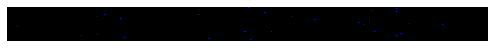

In [0]:
#@title get_topics() { vertical-output: true }
def get_topics(topics):
  string_in_a_list = np.empty([len(topics),1], dtype=str)
  tokens = transform_tokens(topics)
  filtered_tokens, _ , _ = transform_filtered(tokens, string_in_a_list, string_in_a_list)
  stemmed = transform_stemming(filtered_tokens)
  cluster_origins = vectorizer.transform(stemmed)
  plot_coo_matrix(cluster_origins)
  cluster_origins = cluster_origins.toarray()
  return cluster_origins
get_topics(targets)

# Predict Documents

In [0]:
#@title Prediction helper functions { display-mode: "form" }
def estimator_predict_document(document, name):
    dictionary_list = []
    for counter, sentence in enumerate(document.split(".")):
        if len(sentence) != 0:
            vector_matrix = vectorizer.transform([sentence])
            predicted_label = model.predict(vector_matrix)
            sentence_len = len(sentence.split(" "))
            sentence_info = {'company': name, 'sentence#': counter, 'text': sentence,
                             'wordcount': sentence_len, 'label': predicted_label[0]}
            dictionary_list.append(sentence_info)
    dataframe = pd.DataFrame(dictionary_list)
    dataframe["% of total"] = dataframe['wordcount'] / \
        sum(dataframe['wordcount'])
#         (name, sentence, predicted_label)
    return(dataframe)
def prep_for_heatmap(muliple_company_frame):
    company_clusters = muliple_company_frame.groupby(['label', 'company']).agg(
        {'% of total': 'sum'}).unstack(level='company').fillna(0).T

    company_clusters = company_clusters.reset_index(level=0, drop=True)
    return company_clusters


In [0]:
#@title Predict Files { run: "auto", vertical-output: true, display-mode: "form" }
folder_choice =  'Analyze' #@param ["Analyze", "Samdbox"] {type:"string"}

#@markdown Save Documents?
To_Master_List = True #@param ["False", "True"] {type:"raw"}
To_New_List =  True #@param ["False", "True"] {type:"raw"}

def analyze_documents():
  doclist = []
  names = []
  # %cd "
  pathlist = Path(
      "Text_ML_Classification_UMN/%s" % folder_choice).glob('**/*.txt')
# try:
  for path in tqdm(pathlist):
      path_in_str = str(path)
  #     print(path_in_str)
      name = path_in_str.split(".")[0].split("/")[2]
      names.append(name.replace("_", " "))
      # TODO SPLIT PATH TO COMPANY NAME, make Index
      file = open(path, "r", encoding= 'Windows-1252')
      # print "Output of Readlines after appending"
      text = file.readlines()
      doclist.append(text[0])



  analysis_df = pd.DataFrame(list(zip(names, doclist)),
                             columns=['Company', 'Text'])

  analysis_df.head()

  frames = []
  for document, name in zip(doclist, names):
      frame = estimator_predict_document(document, name)
      frames.append(frame)

  muliple_company_frame = pd.concat(frames)
  muliple_company_frame.head()
  grouped_frame = muliple_company_frame.groupby(
    ['company', 'label']).agg({'% of total': 'sum'})
  company_clusters = prep_for_heatmap(muliple_company_frame)
  master_path = "Text_ML_Classification_UMN/Predicting/CSV/master_data.csv"
  master = load_master_data()
  
  if type(master) != "pd.DataFrame" and To_Master_List == True:
      company_clusters.T.to_csv(master_path, header=True,index=True)
  master = load_master_data()

  if type(master) == "pd.DataFrame" and To_Master_List == True:
      master = pd.concat([master, company_clusters.T], ignore_index=True)
      master.to_csv(master_path, index=True)


      # if file does not exist write header 
      
#       with open(master_path, 'a') as f:
#           company_clusters.to_csv(f, header=f.tell()==0)
      
      ##!! THIS IS CAUSING DUPLICATES ##
      
      
       
    
  if To_New_List == True:
    analysis_time = get_time()

    with open(f'Text_ML_Classification_UMN/Predicting/CSV/{analysis_time}.csv', 'w') as f:
        company_clusters.T.to_csv(f, header=True)
#   except IndexError:
#     print("Are there any files in /Analyze?")
#     company_clusters, grouped_frame = len(names), False
  return company_clusters, grouped_frame, muliple_company_frame, master
company_clusters, grouped_frame, muliple_company_frame, master = analyze_documents()
company_clusters.T.head(20)


company,180 Degree Capital Corp,3M Company,AAR Corp,ADT Inc,ASGN Incorporated
label,,,,,
0,0.003855,0.000000,0.018411,0.004173,0.021505
2,0.014554,0.000000,0.000000,0.024425,0.005376
3,0.051040,0.006869,0.036570,0.022184,0.016476
6,0.000000,0.000000,0.009836,0.003998,0.004856
7,0.037948,0.019462,0.016393,0.038921,0.021679
8,0.129262,0.000000,0.000000,0.070638,0.092092
9,0.014820,0.064682,0.100631,0.032947,0.021505
10,0.005117,0.011448,0.016898,0.003251,0.003295
11,0.546687,0.637665,0.677427,0.531102,0.662157


In [0]:
master

,180 Degree Capital Corp,3M Company,AAR Corp,ADT Inc,ASGN Incorporated
label,,,,,
0,0.003855,0.000000,0.018411,0.004173,0.021505
2,0.014554,0.000000,0.000000,0.024425,0.005376
3,0.051040,0.006869,0.036570,0.022184,0.016476
6,0.000000,0.000000,0.009836,0.003998,0.004856
7,0.037948,0.019462,0.016393,0.038921,0.021679
8,0.129262,0.000000,0.000000,0.070638,0.092092
9,0.014820,0.064682,0.100631,0.032947,0.021505
10,0.005117,0.011448,0.016898,0.003251,0.003295
11,0.546687,0.637665,0.677427,0.531102,0.662157


# Visualizations


In [0]:
#@title Stacked Bar { run: "auto", display-mode: "form" }
folder = 'Master' #@param ["Analyze", "Master"]
html = False #@param ["False", "True"] {type:"raw"}
png= True #@param ["False", "True"] {type:"raw"}

sort = 'Bottom Companies' #@param ["False", "Top Companies", "Bottom Companies"]
f = plt.figure()

try:

  if folder == "Master":
    master = load_master_data()
    bar_clusters = master
  else:
     bar_clusters = company_clusters


  if sort != 'False':
    cluster_id = 5 #@param {type:"slider", min:1, max:35, step:1}
  #   cluster_id = str(cluster_id)
    bar_clusters.columns = bar_clusters.columns.map(str)
    if sort == 'Top Companies':
      ascending = False
    if sort == 'Bottom Companies': 
      ascending = True

    bar_clusters = bar_clusters.T.sort_values(
        kind='mergesort', by=[cluster_id], axis=0, ascending=ascending).head(10)
  #     bar_clusters['int_index'] = range(len(bar_clusters))

  # df.plot(x='int_index', y='sorted_values')
  #   except KeyError:
  #     print(f"{cluster_id} is an empty cluster, try another")





  bar_clusters.plot(kind='bar', stacked=True, figsize=(15,10), use_index=True, ax=f.gca())
  plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))


  time = get_time()

  if png == True or html == True:
    plt.savefig(f'Text_ML_Classification_UMN/Predicting/Images/stackedBar{time}.png')

  if html == True:
    print("Make sure Png is located in Text_ML_Classification_UMN/Predicting/Images/ for html to work")
    Html_file= open(f'Text_ML_Classification_UMN/Predicting/Images/stackedBar{time}.html',"w")
    html_str = HTML(
        f'<img src="Text_ML_Classification_UMN/Predicting/Images/stackedBar{time}.png" alt={company_clusters.T.columns.values}>')
    Html_file.close()
except KeyError:
  print("Cluser out of bounds, try a lower number")

Cluser out of bounds, try a lower number


<Figure size 432x288 with 0 Axes>

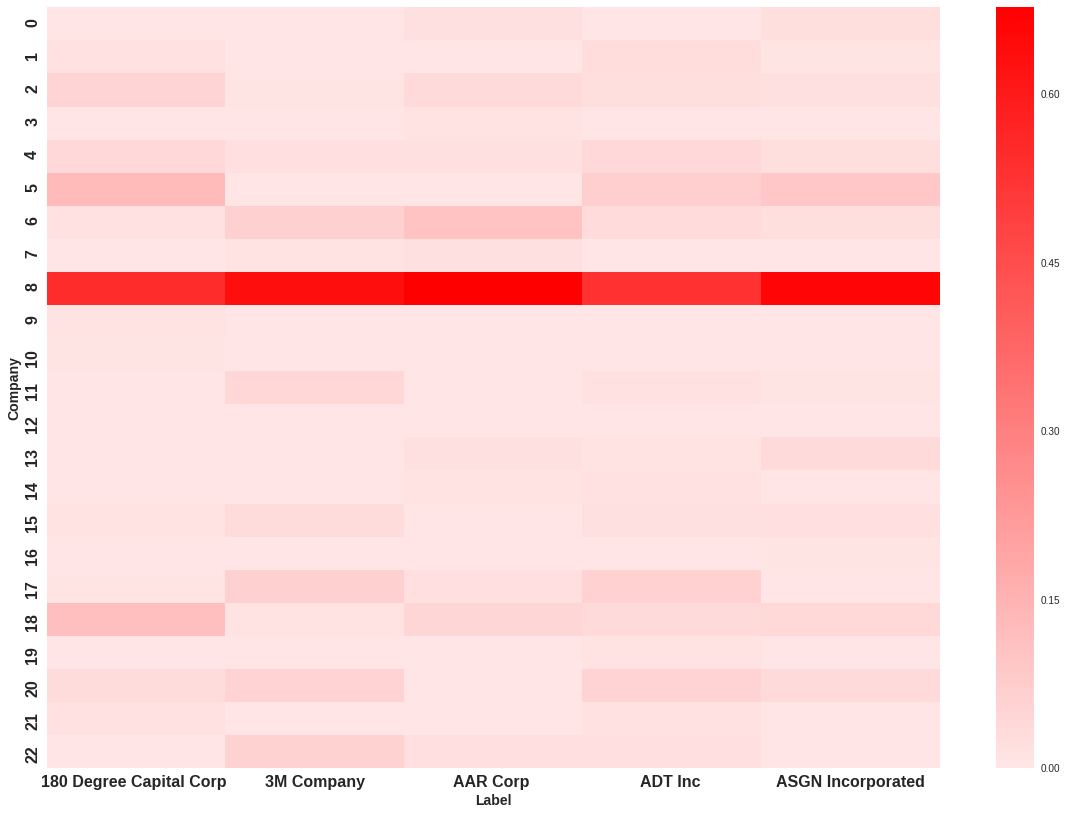

In [0]:
#@title Heatmap { run: "auto", vertical-output: true, display-mode: "form" }
folder = 'Master CSV' #@param ["Analyze", "Master CSV"]


def plot_heatmap(company_clusters, html, png):
    map_time = get_time()

    fig2, ax2 = plt.subplots(figsize=(20, 14))
    cmap = sns.light_palette('red', as_cmap=True)
    if folder == "Master CSV":
      master = load_master_data()
      company_clusters = master.reset_index(drop=True)

    company_clusters.plot(kind='bar', stacked=True, figsize=(15,10), use_index=True, ax=f.gca())

    sns.heatmap(company_clusters, ax=ax2, cmap=cmap)
    

    ax2.set_xlabel('Label', fontdict={'weight': 'bold', 'size': 14})
    ax2.set_ylabel('Company', fontdict={'weight': 'bold', 'size': 14})
    for label in ax2.get_xticklabels():
        label.set_size(16)
        label.set_weight("bold")
    for label in ax2.get_yticklabels():
        label.set_size(16)
        label.set_weight("bold")


    if png == True or html == True:
        plt.savefig(
        "Text_ML_Classification_UMN/Predicting/Images/Heatmap{map_time}.jpg",
        dpi=None, facecolor='w', edgecolor='w',
                orientation='portrait', papertype=None, format=None,
                transparent=False, bbox_inches=None, pad_inches=0.1,
                frameon=None, metadata=None)

    if html == True:
        print(
            "Make sure Png is located in Text_ML_Classification_UMN/Predi" +
            "cting/Images/ for html to work")
        Html_file= open('Text_ML_Classification_UMN/Predicting/Images/Heat'+
                        f'map{time}.html',"w")
        html_str = HTML(
            '<img src="Text_ML_Classification_UMN/Predicting/Images/Heat' + 
            f'map{time}.png" alt={company_clusters.T.columns.values}>')
        Html_file.close()

#@markdown ## Save Image?


html = False #@param ["False", "True"] {type:"raw"}
png= True #@param ["False", "True"] {type:"raw"}

plot_heatmap(company_clusters.T, html, png)


In [0]:
#@title Generate Color Coded Text (Html) { vertical-output: true, display-mode: "form" }
#@markdown Save Text?
html = True #@param ["False", "True"] {type:"raw"}
display_all = False #@param {type:"boolean"}
display_lines = 10 #@param {type:"integer"}


for counter, company in enumerate(muliple_company_frame['company'].unique()):
  company = muliple_company_frame['company'].unique()[counter]
  companyFrame = muliple_company_frame[muliple_company_frame['company'] == company]
  if html == True:
      Html_file= open(f'Text_ML_Classification_UMN/Predicting/Text_Files/{company.replace(" ", "_")}_CC.html',"w")
  display(HTML(f'<h2>{company}</h2>'))


  
  for row in companyFrame.iterrows():
    
    color = colormap[row[1]['label']]
    text = row[1]['text']                
    html_str = HTML(f'<font color="{color}">' +
                       text + f'  ({row[1]["label"]})' + '</font>')
    if row[0] <= display_lines or display_all == True:
        display(html_str)
  if html == True:
    Html_file.close()

In [0]:
#@markdown ## Polar Plots per Cluster
#@markdown this wasnt very effective, and sorting effected how many plots show? 
#@markdwon I think we should get rid of these?

import matplotlib.pyplot as plt
import pandas as pd
from math import pi
# ------- ref  https://python-graph-gallery.com/392-use-faceting-for-radar-chart/
# ------- PART 1: Define a function that do a plot for one line of the dataset!
spider_clusters = company_clusters
spider_clusters['company'] = spider_clusters.index
spider_clusters = spider_clusters.reset_index(drop=True)
spider_clusters.columns = spider_clusters.columns.map(str)

def make_spider( row, title, color):

    # number of variable
    categories=list(df)[1:]
    N = len(categories)

    # What will be the angle of each axis in the plot? (we divide the plot / number of variable)
    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1]

    # Initialise the spider plot
    ax = plt.subplot(2,2,row+1, polar=True, )

    # If you want the first axis to be on top:
    ax.set_theta_offset(pi / 2)
    ax.set_theta_direction(-1)

    # Draw one axe per variable + add labels labels yet
    plt.xticks(angles[:-1], categories, color='grey', size=8)

    # Draw ylabels
    ax.set_rlabel_position(0)
    plt.yticks([.2,.4,.6], ["20%","40%","60%"], color="grey", size=7)
    plt.ylim(0,.8)

    # Ind1
    values=df.loc[row].drop('company').values.flatten().tolist()
    values += values[:1]
    ax.plot(angles, values, color=color, linewidth=2, linestyle='solid')
    ax.fill(angles, values, color=color, alpha=0)

    # Add a title
    plt.title(title, size=11, color='black', y=1.1)

    

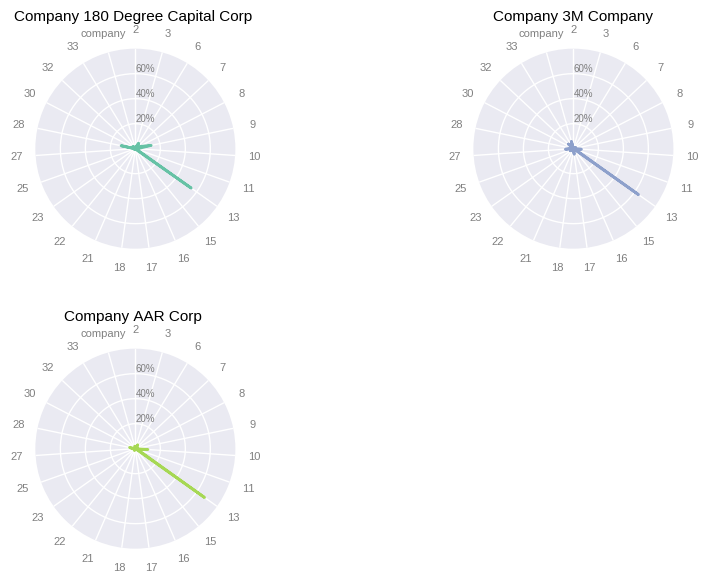

In [0]:
#@title  { run: "auto" }
cluster_id = 7 #@param {type:"slider", min:1, max:35, step:1}
cluster_id = str(cluster_id)
sort = 'Bottom Companies' #@param ["Top Companies", "Bottom Companies"]

spider_clusters = company_clusters
spider_clusters['company'] = spider_clusters.index
spider_clusters = spider_clusters.reset_index(drop=True)
spider_clusters.columns = spider_clusters.columns.map(str)
try:
  spider_clusters = spider_clusters[spider_clusters[cluster_id] != 0]
except KeyError:
  print(f"{cluster_id} is an empty cluster, try another")
  cluster_id = "7"


if sort == 'Top Companies':
  ascending = False
else: 
  ascending = True
# ------- PART 2: Apply to all individuals
# initialize the figure
my_dpi=100
plt.figure(figsize=(1000/my_dpi, 1000/my_dpi), dpi=my_dpi)
plt.subplots_adjust(left=None, bottom=0.1, right=None,
                    top=0.6, wspace=.3, hspace=.5)

# Create a color palette:
my_palette = plt.cm.get_cmap("Set2", len(spider_clusters.index))

spider_clusters = spider_clusters.sort_values(
    kind='mergesort', by=[cluster_id], axis=0, ascending=ascending)


df = spider_clusters.head(4)
# Loop to plot
for row in range(0, len(df.index)):
    try:
      make_spider( row=row, title='Company '+df['company'][row], color=my_palette(row))
    except KeyError:
      pass

# Nearest Neighbors

In [0]:
from sklearn.neighbors import NearestNeighbors

model_tf_idf = NearestNeighbors(metric='cosine', algorithm='brute')
model_tf_idf.fit(sparseMatrix)

NearestNeighbors(algorithm='brute', leaf_size=30, metric='cosine',
         metric_params=None, n_jobs=None, n_neighbors=5, p=2, radius=1.0)

In [0]:
from sklearn.manifold import TSNE
from sklearn.decomposition import TruncatedSVD
sparseMatrix.shape

(35286, 354)

In [0]:
k = n_cluseters
tfs_reduced = TruncatedSVD(n_components=k, random_state=0).fit_transform(sparseMatrix)
tfs_embedded = TSNE(n_components=2, perplexity=40, verbose=2).fit_transform(tfs_reduced)


NameError: ignored

In [0]:
fig = plt.figure(figsize = (10, 10))
ax = plt.axes()
plt.scatter(tfs_embedded[:, 0], tfs_embedded[:, 1], marker = "x", c = model.labels_)
plt.show()